# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [125]:
#Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error


import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [ ]:
# Feature scaling involves transforming numerical features in your dataset to 
# ensure that they are on a similar scale. This is crucial for many machine 
# learning algorithms that rely on the distances between data points 
# (e.g., kNN, SVM, Gradient Descent in linear models).

In [12]:
null_counts = spaceship.isnull().sum()
print(null_counts[null_counts > 0])

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64


In [15]:
spaceship[spaceship.isnull().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False
23,0020_03,Earth,True,E/0/S,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,9250_01,Europa,False,E/597/P,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,28.0,188.0,Chain Reedectied,True
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,Annah Gilleyons,True
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True


In [18]:
spaceship = spaceship.dropna()
spaceship

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [21]:
spaceship['Cabin'].sort_values(ascending = True).unique()
# Extract the first character of each entry
spaceship['CabinLabel'] = spaceship['Cabin'].str[0]

In [24]:
spaceship['CabinLabel'].sort_values(ascending = True).unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype=object)

In [27]:
spaceship_cleaned = spaceship.drop(columns=['PassengerId', 'Name', 'Cabin'])

spaceship_cleaned

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinLabel
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E


In [30]:
numerical_features = spaceship_cleaned.select_dtypes(include=['number'])

numerical_features.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


In [33]:
categorical_columns = ['HomePlanet', 'Destination', 'CabinLabel']
df_spaceship = pd.get_dummies(spaceship_cleaned, columns=categorical_columns, drop_first=True)

df_spaceship

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinLabel_B,CabinLabel_C,CabinLabel_D,CabinLabel_E,CabinLabel_F,CabinLabel_G,CabinLabel_T
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,True,False,False,True,True,False,False,False,False,False,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,False,False,False,True,False,False,False,False,True,False,False
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,False,False,True,False,False,False,False,False,False,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,False,False,True,False,False,False,False,False,False,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,False,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,True,False,False,False,False,False,False,False,False,False,False
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False,False,True,False
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,False,False,False,True,False,False,False,False,False,True,False
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,True,False,False,False,False,False,False,True,False,False,False


**Perform Train Test Split**

In [38]:
features = df_spaceship.drop(columns = ["Transported"], axis=1) #X
target = df_spaceship["Transported"] #y
df_spaceship

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinLabel_B,CabinLabel_C,CabinLabel_D,CabinLabel_E,CabinLabel_F,CabinLabel_G,CabinLabel_T
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,True,False,False,True,True,False,False,False,False,False,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,False,False,False,True,False,False,False,False,True,False,False
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,False,False,True,False,False,False,False,False,False,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,False,False,True,False,False,False,False,False,False,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,False,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,True,False,False,False,False,False,False,False,False,False,False
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False,False,True,False
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,False,False,False,True,False,False,False,False,False,True,False
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,True,False,False,False,False,False,False,True,False,False,False


In [45]:
# Feature Scaling for numerical columns
scaler = StandardScaler()
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [57]:
X_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinLabel_B,CabinLabel_C,CabinLabel_D,CabinLabel_E,CabinLabel_F,CabinLabel_G,CabinLabel_T
3432,True,0.213728,False,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534,False,True,False,True,False,False,False,True,False,False,False
7312,True,-1.713011,False,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534,False,False,False,True,False,False,False,False,False,True,False
2042,False,0.076104,False,-0.345756,-0.144750,-0.309494,0.730673,-0.269534,False,False,False,True,False,False,False,False,True,False,False
4999,False,-0.818454,False,-0.325599,-0.285355,0.670924,0.047065,-0.268647,False,True,False,True,False,False,False,True,False,False,False
5755,True,-0.199145,False,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534,False,False,False,True,False,False,False,False,False,True,False


In [60]:
y_train.head()

3432    False
7312     True
2042    False
4999    False
5755     True
Name: Transported, dtype: bool

In [65]:
normalizer = StandardScaler()

In [68]:
normalizer.fit(X_train)

StandardScaler()

In [71]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [74]:
X_train_norm

array([[ 1.3539734 ,  0.22051462, -0.16314854, ..., -0.69021015,
        -0.65429971, -0.01945879],
       [ 1.3539734 , -1.70452544, -0.16314854, ..., -0.69021015,
         1.52835159, -0.01945879],
       [-0.73856695,  0.08301176, -0.16314854, ...,  1.44883409,
        -0.65429971, -0.01945879],
       ...,
       [-0.73856695,  0.49552034, -0.16314854, ..., -0.69021015,
        -0.65429971, -0.01945879],
       [-0.73856695,  0.35801748,  6.12938358, ..., -0.69021015,
        -0.65429971, -0.01945879],
       [-0.73856695, -1.01701113, -0.16314854, ..., -0.69021015,
        -0.65429971, -0.01945879]])

In [84]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)

In [86]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

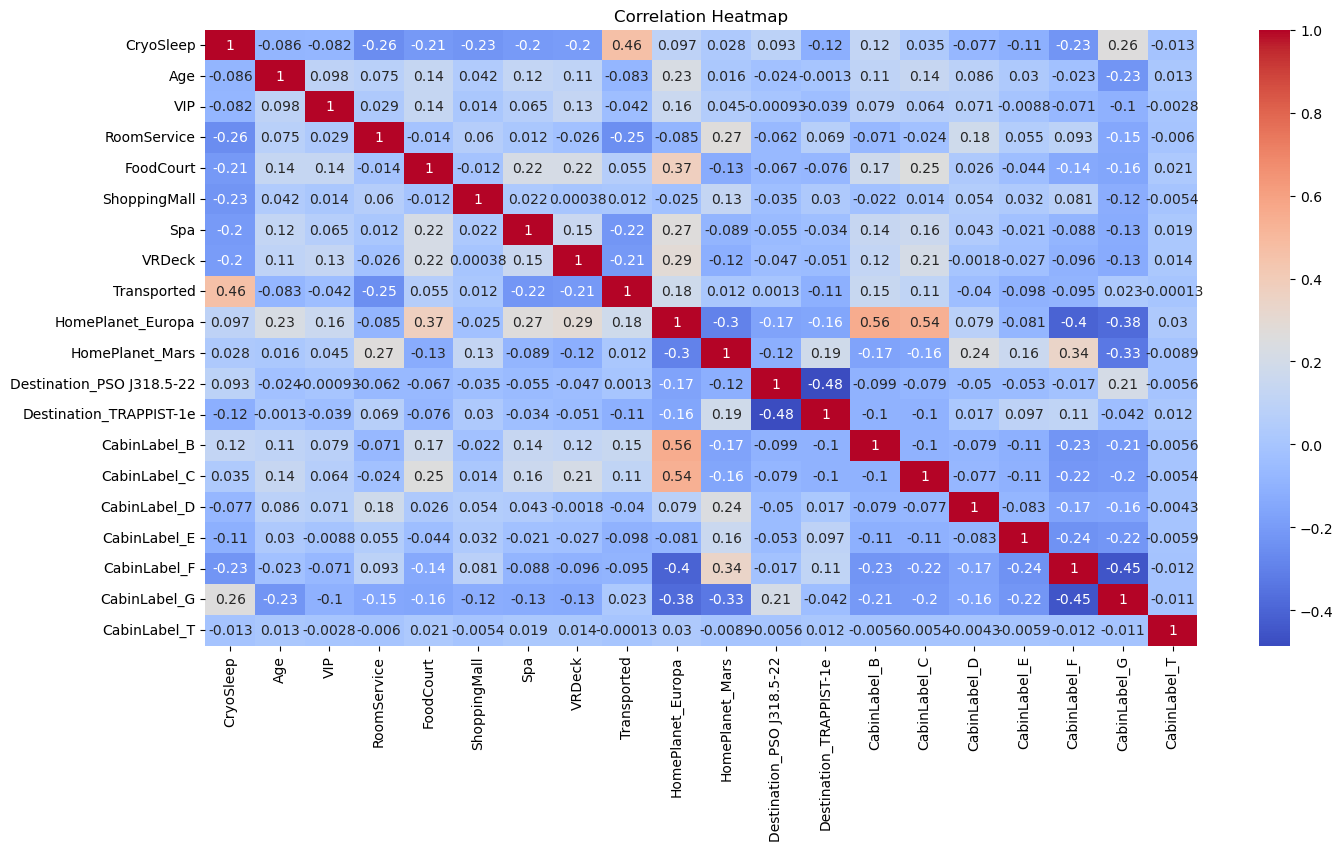

In [88]:
plt.figure(figsize=(16, 8))
sns.heatmap(df_spaceship.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [101]:
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)

In [104]:
bagging_reg.fit(X_train_norm, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                 max_samples=1000, n_estimators=100)

In [129]:
pred = bagging_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", bagging_reg.score(X_test_norm, y_test))

MAE 0.2792982799774774
RMSE 0.38037582415333776
R2 score 0.42125692959867633


- Random Forests

In [117]:
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=20)

In [120]:
forest.fit(X_train_norm, y_train)

RandomForestRegressor(max_depth=20)

In [131]:
pred = forest.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", forest.score(X_test_norm, y_test))

MAE 0.27044292977439965
RMSE 0.38498880284605014
R2 score 0.4071344867326605


- Gradient Boosting

In [140]:
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)

In [142]:
gb_reg.fit(X_train_norm, y_train)

GradientBoostingRegressor(max_depth=20)

In [143]:
pred = gb_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", gb_reg.score(X_test_norm, y_test))

MAE 0.26230316093942574
RMSE 0.42451174869915786
R2 score 0.2791591008655321


- Adaptive Boosting

In [146]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)

In [148]:
ada_reg.fit(X_train_norm, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                  n_estimators=100)

In [150]:
pred = ada_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", ada_reg.score(X_test_norm, y_test))

MAE 0.24596941660279698
RMSE 0.4237461985206146
R2 score 0.28175663695731146


Which model is the best and why?

In [ ]:
#comment here
"""
Comparisons:
Model	            MAE     RMSE    R² Score
Bagging/Pasting	    0.2793	0.3804	0.4213
Random Forests	    0.2704	0.3850	0.4071
Gradient Boosting	0.2623	0.4245	0.2792
Adaptive Boosting	0.2460	0.4237	0.2818

Best Overall Model - AdaBoosting, based on its lowest MAE 
(better error performance for prediction). But, it has a moderate R² score.
It's best for minimizing Prediction Error (MAE/RMSE). 
Best for Variance Explanation - Bagging and Pasting (highest R²). Best for 
Explaining Variability (R²).
"""
